In [17]:
import keras
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

keras.__version__

'2.4.3'

# Text processing

First, we will look at simple operations with text: tokenisation, lemmatisation etc. We need them to make all words look similar to the machine.

- Cleaning texts (regular expressions or one of the following)
- Tokenization is to break text into units (words and sentences) : "I have a dog." --> "I", "have", "a", "dog", "."
- Stemming and lemmatization : reducing words into their common stem or lemma. "has" -> "have", "dogs" -> "dog” etc.
- Removal of stop words ( common words such as “a” and “the” that appear in most documents but often provide no significant meaning).

In [18]:
text = "This is Felipe's class, isn't it?"

You can use the following tokenizers to work with your text, depending on the task in hand:
- WhitespaceTokenizer
- TreebankWordTokenizer
- WordPunctTokenizer

In [19]:
#Tokenize a string on whitespace (space, tab, newline). You can use the string split() method instead.
tokenizer = nltk.tokenize.WhitespaceTokenizer()
tokenizer.tokenize(text)

['This', 'is', "Felipe's", 'class,', "isn't", 'it?']

The Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank. 
This is the method that is invoked by word_tokenize(). 
It assumes that the text has already been segmented into sentences, e.g. using sent_tokenize().

This tokenizer performs the following steps:
- split standard contractions, e.g. don't -> do n't and they'll -> they 'll
- treat most punctuation characters as separate tokens
- split off commas and single quotes, when followed by whitespace
- separate periods that appear at the end of line

In [20]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokenizer.tokenize(text)

['This', 'is', 'Felipe', "'s", 'class', ',', 'is', "n't", 'it', '?']

In [21]:
# Tokenize a text into a sequence of alphabetic and non-alphabetic characters, using the regexp \w+|[^\w\s]+.
tokenizer = nltk.tokenize.WordPunctTokenizer()
tokenizer.tokenize(text)

['This', 'is', 'Felipe', "'", 's', 'class', ',', 'isn', "'", 't', 'it', '?']

Lemmatization and stemming: used for extracting lemma and stem of words



In [22]:
text = "feet wolves cats talked"
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)
print(tokens)

['feet', 'wolves', 'cats', 'talked']


In [23]:
stemmer = nltk.stem.PorterStemmer()
" ".join(stemmer.stem(token) for token in tokens)

'feet wolv cat talk'

# TFIDF

In information retrieval, tf–idf or TFIDF, short for term **frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes.


In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform. Read more [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
texts = [
    "good movie", "not a good movie", "did not like", 
    "i like it", "good one"
]
# using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
features = tfidf.fit_transform(texts)
pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names()
)

,good movie,like,movie,not
0,0.707107,0.000000,0.707107,0.000000
1,0.577350,0.000000,0.577350,0.577350
2,0.000000,0.707107,0.000000,0.707107
3,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000


# One-hot encoding

In [25]:
from keras.preprocessing.text import Tokenizer

samples = ['Mary has a ball', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer = Tokenizer(num_words=10)
# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

In [26]:
one_hot_results[1]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

Try changing "The" in the second snetence to "a", the result will change. Why?

# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors (i.e. "dense" vectors, as opposed to sparse vectors). 

Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
Word embeddings pack more information into far fewer dimensions. 

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Learning word embeddings with the `Embedding` layer

The geometric relationships between word vectors should reflect the semantic relationships between these words. 
It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [27]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [28]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [29]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6848 - acc: 0.5626 - val_loss: 0.6141 - val_acc: 0.6984
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5657 - acc: 0.7425 - val_loss: 0.5243 - val_acc: 0.7312
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4694 - acc: 0.7873 - val_loss: 0.4982 - val_acc: 0.7490
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4239 - acc: 0.8101 - val_loss: 0.4939 - val_acc: 0.7496
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3904 - acc: 0.8286 - val_loss: 0.4927 - val_acc: 0.7552
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3737 - acc: 0.8352 - val_loss: 0.4983 - val_acc: 0.7546
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3482 - acc: 0.8494 - val_loss: 0.5016 - val_acc: 0.7574
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 0.

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nTest accuracy:', test_acc)

782/782 [==============================] - 1s 943us/step - loss: 0.5114 - acc: 0.7608

Test accuracy: 0.7608000040054321


We get to a validation accuracy of ~75%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

# Plot the training history

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


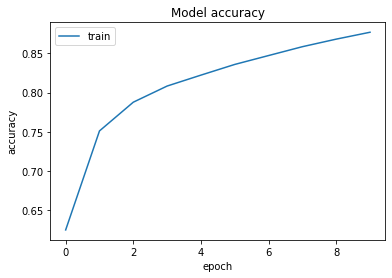

In [32]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()